<a href="https://colab.research.google.com/github/BlueBlazin/nlp_from_ground_up/blob/master/rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
import numpy as np
import pandas as pd
import plotly.express as px

First, some basic functions.

In [90]:
def softmax(x):
    x -= np.max(x)
    x = np.exp(x)
    return x / np.sum(x)

In [91]:
def cross_entropy(t, pred):
    target = np.zeros_like(pred)
    target[t] = 1
    return -np.sum(target * np.log(pred))

In [92]:
def loss_fn(ts, ys):
    return sum(cross_entropy(t, y) for t, y in zip(ts, ys)) / len(ts)

The vanilla RNN is just $\mathbf{h_t} = \text{tanh}(\mathbf{W_x} \mathbf{x_t} + \mathbf{W_h} \mathbf{h_{t-1}} + \mathbf{b_h})$.

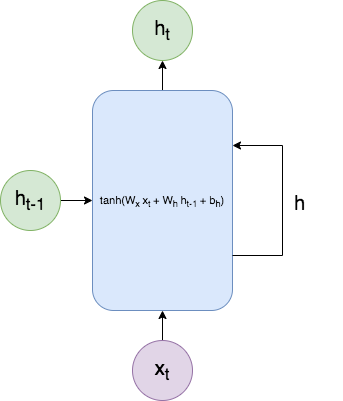

In [93]:
def rnn_cell(x, hprev, Wx, Wh, bh):
    return np.tanh(Wx @ x + Wh @ hprev + bh)

In [94]:
def forward_pass(xs, h, Wx, Wh, bh, Wy, by):
    hs = []
    ys = []

    for x in xs:
        h = rnn_cell(x, h, Wx, Wh, bh)
        hs.append(h)

        y = softmax(Wy @ h + by)
        ys.append(y)

    return ys, hs

#### Backward Pass

When it comes to writing backpropagation by hand it's helpful to be explicit by drawing the computation graph in steps of simple operations.

Note: If the emphasis is on simple operations, why the `cross_ent(softmax(r_t))` step? That's because that entire operation has a very simple gradient (explained below).

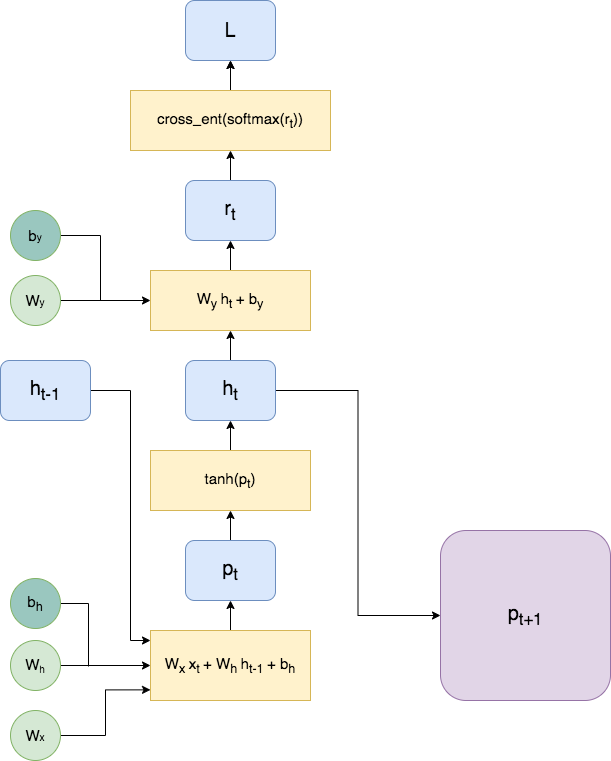

In [95]:
def backward_pass(xs, ys, hs, ts, Wy, by, Wx, Wh, bh):
    dWy = np.zeros_like(Wy)
    dby = np.zeros_like(by)

    dWx = np.zeros_like(Wx)

    dWh = np.zeros_like(Wh)
    dbh = np.zeros_like(bh)

    dpnext = np.zeros_like(hs[0])

    for t in reversed(range(len(ys))):
        y = ys[t]
        h = hs[t]
        x = xs[t]
        hprev = hs[t - 1]

        dr = y.copy()
        dr[ts[t]] -= 1

        dh = Wy.T @ dr + Wh @ dpnext

        dWy += dr @ h.T
        dby += dr

        dp = (1 - h * h) * dh

        dWx += dp @ x.T

        dWh += dp @ hprev.T
        dbh += dp

        dpnext = dp.copy()

    return dWy, dby, dWx, dWh, dbh

In [96]:
xs = [np.array([[1, 0, 0, 0]]).T, np.array([[0, 1, 0, 0]]).T, np.array([[0, 0, 1, 0]]).T]

ts = [1, 2, 3]

Wx = np.random.randn(3, 4)

Wh = np.random.randn(3, 3)
bh = np.random.randn(3, 1)

Wy = np.random.randn(4, 3)
by = np.random.randn(4, 1)

hzero = np.zeros((3, 1))

In [97]:
alpha = 0.01
losses = []

for i in range(5000):
    ys, hs = forward_pass(xs, hzero, Wx, Wh, bh, Wy, by)
    hs.append(hzero)

    losses.append(loss_fn(ts, ys))

    if i % 500 == 0:
        print(losses[-1])

    dWy, dby, dWx, dWh, dbh = backward_pass(xs, ys, hs, ts, Wy, by, Wx, Wh, bh)

    Wy -= alpha * dWy
    by -= alpha * dby

    Wx -= alpha * dWx

    Wh -= alpha * dWh
    bh -= alpha * dbh

3.0307898212035824
0.07566008120700411
0.031084838584770347
0.018760167990325097
0.013534119302646643
0.010644586057773776
0.008805406526313253
0.007528408240002268
0.006587787851315664
0.005864688598973706


In [102]:
df = pd.DataFrame({'Epoch': range(len(losses)), 'Loss': losses})
fig = px.line(df, x="Epoch", y="Loss", title='Training loss')
fig.show()

In [105]:

import tensorflow_datasets as tfds

d = tfds.load(name='tiny_shakespeare')['train']
# d = d.map(lambda x: tf.strings.unicode_split(x['text'], 'UTF-8'))
# # train split includes vocabulary for other splits
# vocabulary = sorted(set(next(iter(d)).numpy()))
# d = d.map(lambda x: {'cur_char': x[:-1], 'next_char': x[1:]})
# d = d.unbatch()

In [109]:
list(next(iter(d))['text'].numpy())

[70,
 105,
 114,
 115,
 116,
 32,
 67,
 105,
 116,
 105,
 122,
 101,
 110,
 58,
 10,
 66,
 101,
 102,
 111,
 114,
 101,
 32,
 119,
 101,
 32,
 112,
 114,
 111,
 99,
 101,
 101,
 100,
 32,
 97,
 110,
 121,
 32,
 102,
 117,
 114,
 116,
 104,
 101,
 114,
 44,
 32,
 104,
 101,
 97,
 114,
 32,
 109,
 101,
 32,
 115,
 112,
 101,
 97,
 107,
 46,
 10,
 10,
 65,
 108,
 108,
 58,
 10,
 83,
 112,
 101,
 97,
 107,
 44,
 32,
 115,
 112,
 101,
 97,
 107,
 46,
 10,
 10,
 70,
 105,
 114,
 115,
 116,
 32,
 67,
 105,
 116,
 105,
 122,
 101,
 110,
 58,
 10,
 89,
 111,
 117,
 32,
 97,
 114,
 101,
 32,
 97,
 108,
 108,
 32,
 114,
 101,
 115,
 111,
 108,
 118,
 101,
 100,
 32,
 114,
 97,
 116,
 104,
 101,
 114,
 32,
 116,
 111,
 32,
 100,
 105,
 101,
 32,
 116,
 104,
 97,
 110,
 32,
 116,
 111,
 32,
 102,
 97,
 109,
 105,
 115,
 104,
 63,
 10,
 10,
 65,
 108,
 108,
 58,
 10,
 82,
 101,
 115,
 111,
 108,
 118,
 101,
 100,
 46,
 32,
 114,
 101,
 115,
 111,
 108,
 118,
 101,
 100,
 46,
 10,
 10,
 70,
 105,
 11